## Object Detection and Segmentation with OpenCV and Tensorflow mask RCNN

Here we show how to detect and also segment images based on Tensorflow based models. Detection is identifying a bounding box, segmentation requires identifying the pixels can belong to the object.

In [1]:
import numpy as np
import cv2 as cv2
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In this section we will read the coco labels file. This file contains the labels of the object the model was trained against. We will also create a COLORS array which will give a different color for each label. Note coco has 90 labels by default.

In [2]:
label_file="model_data/object_detection_classes_coco.txt"
LABELS = open(label_file).read().strip().split("\n")
np.random.seed(42) #Set seed so that we get the same results everytime
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [3]:
threshold=0.9

The DNN module from CV2 supports reading of tensorflow trained object detection models. We need to load the weight and config for this. For more on this topic refer to 
https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

In [4]:
weights="model_data/mask_rcnn_frozen_inference_graph.pb"
config="model_data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

In [5]:
net = cv2.dnn.readNetFromTensorflow(weights, config)

Reading the image file and converting it to a blob for processing

In [6]:
img = cv2.imread('images/dining_table.jpg')

In [7]:
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

In [8]:
net.setInput(blob)

This model returns both masks and boxes. 

In [9]:
(boxes, masks) = net.forward(["detection_out_final",
		"detection_masks"])
print ("Shape of boxes", boxes.shape)
print ("Shape of masks", masks.shape)

Shape of boxes (1, 1, 100, 7)
Shape of masks (100, 90, 15, 15)


The boxes have classID, confidence scores and 4 points identifying the bounding box. This bounding box is normalised and has to be multipied by the actual size of the image to get actual values.

The masks have 

- 100 detections 
- Each detection has 90 classes
- There coordinates of a 15 pointed polygon, each containing a confidence value.


If the box probability exceeds the threshold, we also process the mask polygons
- Map it to the bounding box and identify all pixels that the mask covers
- If the pixel confidence exceeds threshold create a mask 
- ROI is Region of Interest in the actual picture. Its color of all pixels in the ROI
- The color of ROI is made into blend of its actual colors and color allocated to classID
Finally everything is printed

In [10]:
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object,       
        mask = masks[i, classID]
        print ("Shape of individual mask", mask.shape)
        
        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)
        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)
        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

Shape of individual mask (15, 15)
Mask after resize (328, 148)
Mask after threshold (328, 148)
ROI Shape (12764, 3)
wine glass [156, 21, 112]
Shape of individual mask (15, 15)
Mask after resize (154, 81)
Mask after threshold (154, 81)
ROI Shape (6072, 3)
vase [166, 56, 167]
Shape of individual mask (15, 15)
Mask after resize (344, 83)
Mask after threshold (344, 83)
ROI Shape (13497, 3)
bottle [209, 226, 77]


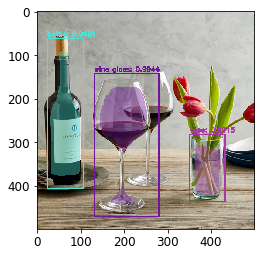

In [11]:
plt.imshow(fixColor(img))